## Nạp tập dữ liệu


In [9]:
import os
import pandas as pd
from cv2.utils import cv2
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Hàm lấy tập dữ liệu:
# Input: n_sample -> Số lượng mẫu
# Output: Tập n_sample mẫu dữ liệu và nhãn 
def LoadDataset(n_sample):
    outside_path = "../dataset/Image/Face2/all/"
    folders = ["female_face_image", "male_face_image"]
    images = []
    labels = []
    count = 0
    for folder in folders:
        n_eachClass = n_sample/len(folders)
        for path in os.listdir(outside_path+folder):
            if count >= n_eachClass*(folders.index(folder)+1):
                break
            if os.path.isfile(os.path.join(outside_path+folder, path)):
                labels.append(folders.index(folder))
                count += 1
                images.append(cv2.imread(os.path.join(outside_path+folder, path)))
    return images, labels

Tập dữ liệu có kích thước 1000 mẫu

In [12]:
dataset, labels = LoadDataset(1000)

In [13]:
print(len(dataset))
labels = pd.DataFrame(labels)
print(labels.value_counts())

1000
0    500
1    500
dtype: int64


0 là nhãn của nữ <br />
1 là nhãn của nam

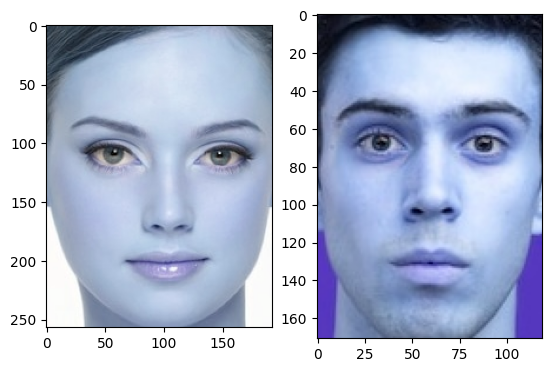

In [14]:
plt.subplot(121)
plt.imshow(dataset[0])
plt.subplot(122)
plt.imshow(dataset[503])

## Tiền xử lý dữ liệu ảnh

#### Thay đổi kích thước

In [5]:
SIZE = (100,100)

In [6]:
dataset = [cv2.resize(data, SIZE) for data in dataset]

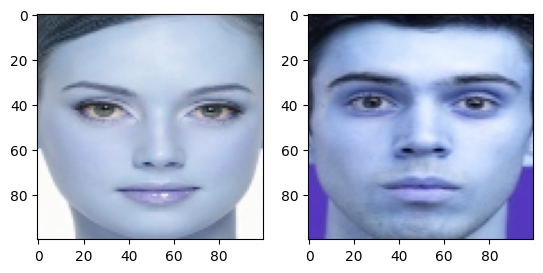

In [8]:
plt.subplot(121)
plt.imshow(dataset[0])
plt.subplot(122)
plt.imshow(dataset[503])

In [7]:
dataset = [cv2.cvtColor(data, cv2.COLOR_BGR2GRAY) for data in dataset]

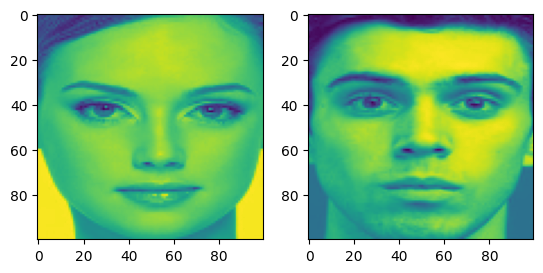

In [8]:
plt.subplot(121)
plt.imshow(dataset[0])
plt.subplot(122)
plt.imshow(dataset[503])

## Sử dụng Eigen Face trích xuất đặc trưng của dữ liệu ảnh

In [7]:
from sklearn.model_selection import train_test_split

In [12]:
class EigenFace:
    def __init__(self) -> None:
        self.dataset = None
        self.K = 0
        self.Keigenvector = None
        self.image_shape = 0
    
    def fit(self,dataset, K = 100):
        self.image_shape = np.array(dataset).shape[1:3]
        self.dataset = np.array([np.array(data).reshape((self.image_shape[0] * self.image_shape[1], )) for data in dataset])
        self.K = K
        self._process()
    
    def _process(self):
        average = sum(np.array(self.dataset) / len(self.dataset))
        dataset_after_subtract = np.array([arr - average for arr in self.dataset])
        inv = np.linalg.pinv(dataset_after_subtract)
        C_quote = dataset_after_subtract.dot(dataset_after_subtract.T)

        w, v = np.linalg.eig(C_quote)
        Keigenvalue = w[0:self.K]
        Keigenvector = v[:, 0:self.K]
        Keigenvector = inv.dot(Keigenvector)
        Keigenvector = Keigenvector.astype(dtype='float64')
        self.Keigenvector = Keigenvector
    
    def get_Feature_Vector(self, images):
        if len(images.shape) != 3:
            raise Exception("Chiều đầu vào dữ liệu khác 3")
        
        images = images.reshape(-1, self.image_shape[0] * self.image_shape[1])
        inv2 = np.linalg.pinv(self.Keigenvector)
        W = inv2.dot(images.T)
        # data_result = self.Keigenvector.dot(W.reshape(-1,1))
        return W


In [8]:
X_train, X_rem, y_train, y_rem = train_test_split(np.array(dataset),labels, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

C:\Users\DELL\AppData\Local\Temp\ipykernel_21092\827581811.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train, X_rem, y_train, y_rem = train_test_split(np.array(dataset),labels, train_size=0.8)


In [9]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(800,)
(100,)
(100,)


In [25]:
counts = 0
os.makedirs("dataset/SmallDS/train/female_face_image/", exist_ok = True)
os.makedirs("dataset/SmallDS/train/male_face_image/", exist_ok = True)
os.makedirs("dataset/SmallDS/val/female_face_image/", exist_ok = True)
os.makedirs("dataset/SmallDS/val/male_face_image/", exist_ok = True)
os.makedirs("dataset/SmallDS/test/female_face_image/", exist_ok = True)
os.makedirs("dataset/SmallDS/test/male_face_image/", exist_ok = True)
for count in range(len(X_train)):
    counts +=1
    if y_train.values[count][0] == 0:
        fp = f'dataset/SmallDS/train/female_face_image/{counts}.jpg'
    else:
        fp = f'dataset/SmallDS/train/male_face_image/{counts}.jpg'
    cv2.imwrite(fp, X_train[count])
for count in range(len(X_valid)):
    counts +=1
    if y_valid.values[count][0] == 0:
        fp = f'dataset/SmallDS/val/female_face_image/{counts}.jpg'
    else:
        fp = f'dataset/SmallDS/val/male_face_image/{counts}.jpg'
    cv2.imwrite(fp, X_valid[count])
for count in range(len(X_test)):
    counts +=1
    if y_test.values[count][0] == 0:
        fp = f'dataset/SmallDS/test/female_face_image/{counts}.jpg'
    else:
        fp = f'dataset/SmallDS/test/male_face_image/{counts}.jpg'
    cv2.imwrite(fp, X_test[count])

In [15]:
eigen = EigenFace()
eigen.fit(X_train, K=100)

In [16]:
X_train_W = eigen.get_Feature_Vector(X_train).T
X_val_W = eigen.get_Feature_Vector(X_valid).T
X_test_W = eigen.get_Feature_Vector(X_test).T

Đã có được tập vector đặc trưng cho từng dữ liệu: <br />
X_train_W: 800 x 100 <br />
X_val_W: 100 x 100 <br />
X_test_W: 100 x 100

## Sử dụng các mô hình học máy để phân loại dữ liệu

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lgr = LogisticRegression(max_iter=10000)
lgr.fit(X_train_W, y_train.values.reshape(-1,))
pass

In [18]:
np.round(lgr.predict(X_val_W))
score_on_val = accuracy_score(y_valid,np.round(lgr.predict(X_val_W)))
np.round(lgr.predict(X_test_W))
score_on_test = accuracy_score(y_test,np.round(lgr.predict(X_test_W)))
print("Accuracy on validation dataset:",score_on_val)
print("Accuracy on test dataset:",score_on_test)

Accuracy on validation dataset: 0.84
Accuracy on test dataset: 0.82


### Tìm siêu tham số tối ưu

#### Tìm K

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


54


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


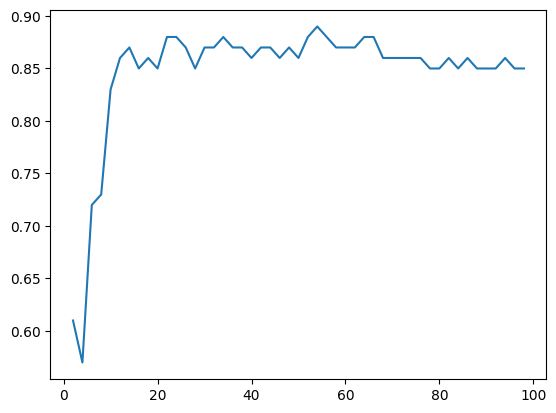

In [25]:
history = []

eigen = EigenFace()
Ks = range(2,100,2)
for K in Ks:
    eigen.fit(X_train, K=K) 
    X_train_W = eigen.get_Feature_Vector(X_train).T
    X_val_W = eigen.get_Feature_Vector(X_valid).T

    lgr = LogisticRegression(max_iter=2000)
    lgr.fit(X_train_W, y_train.values.reshape(-1,))
    point = accuracy_score(y_valid,np.round(lgr.predict(X_val_W)))
    history.append(point)
plt.plot(Ks,(history))
KBest = Ks[history.index(max(history))]

In [17]:
import mediapipe as mp
def HeadDirect(images):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    # To improve performance
    directs = []
    for image in images:
        image.flags.writeable = False

        # Get the result
        results = face_mesh.process(image)

        # To improve performance
        image.flags.writeable = True

        # Convert the color space from RGB to BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        img_h, img_w, img_c = image.shape
        face_3d = []
        face_2d = []

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for idx, lm in enumerate(face_landmarks.landmark):
                    if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                        if idx == 1:
                            nose_2d = (lm.x * img_w, lm.y * img_h)
                            nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                        x, y = int(lm.x * img_w), int(lm.y * img_h)

                        # Get the 2D Coordinates
                        face_2d.append([x, y])

                        # Get the 3D Coordinates
                        face_3d.append([x, y, lm.z])       
                
                # Convert it to the NumPy array
                face_2d = np.array(face_2d, dtype=np.float64)

                # Convert it to the NumPy array
                face_3d = np.array(face_3d, dtype=np.float64)

                # The camera matrix
                focal_length = 1 * img_w

                cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                        [0, focal_length, img_w / 2],
                                        [0, 0, 1]])

                # The distortion parameters
                dist_matrix = np.zeros((4, 1), dtype=np.float64)

                # Solve PnP
                success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

                # Get rotational matrix
                rmat, jac = cv2.Rodrigues(rot_vec)

                # Get angles
                angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

                # Get the y rotation degree
                x = angles[0] * 360
                y = angles[1] * 360
                z = angles[2] * 360
            directs.append((x, y, z))
        else:
            directs.append((None, None, None))
    return np.array(directs)

In [19]:
directs = np.array(HeadDirect(dataset))
print(directs.shape)
print(directs)

(1000, 3)
[[-9.542927245735726 -14.397530318923968 2.3915387929356853]
 [8.038051873271518 -32.85293070231871 4.3390974926853705]
 [-26.27175180741813 -16.973268965134004 2.3048556043826247]
 ...
 [-9.732233101260487 -2.0495063885082963 2.3197980421073305]
 [-48.87983414032654 -39.129718132751165 4.683555650852895]
 [4.773380417835694 5.379128174916633 1.3851297142899586]]
